# Libraries

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.non_parametric_tests import *
from utils.PerformanceProfiles  import *
from utils.PerformanceMetrics   import RegressionEvaluation

# Import data

In [41]:
from os import listdir
from os.path import isfile, join

path = 'Predictions/'
Files = [f for f in listdir( path ) if isfile(join(path, f))]

print('[INFO] Number of methods: ', len(Files) )

[INFO] Number of methods:  8


In [42]:
Results = []
df      = None
for file in Files:
    # Get method
    Method = file.split('.')[0] 
    print('Model: ', Method)
    
    # Load data
    temp = pd.read_csv(path + file, index_col = 0)
    
    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( temp )
    Results.append( [Method, MAE, RMSE, MAPE, SMAPE, 100*R2] )
    
    # Calculate Absolute Errors
    temp[ Method ] = (temp.iloc[:,0] - temp.iloc[:,1]).abs().round(4)
    # Keep only errors
    temp = temp[ Method ]
    
    if (df is None):
        df = temp
    else:
        df = pd.concat([df, temp], axis=1)
        

# df.head( 3 )

Model:  NBeats
Model:  Hybrid
Model:  RF
Model:  RF_diff
Model:  NBeats_diff
Model:  Seq2Seq_LSTM_diff
Model:  Seq2Seq_LSTM
Model:  Convolutional


# Performance evaluation based on metrics

In [43]:
Results = pd.DataFrame(data = Results, columns = ['Method', 'MAE', 'RMSE', 'MAPE', 'SMAPE', 'R2'] )

Results['MAE']   = Results['MAE'].apply(lambda x: np.round(x,3))
Results['RMSE']  = Results['RMSE'].apply(lambda x: np.round(x,3))
Results['MAPE']  = Results['MAPE'].apply(lambda x: np.round(x,3))
Results['SMAPE'] = Results['SMAPE'].apply(lambda x: np.round(x,3))
Results['R2']    = Results['R2'].apply(lambda x: np.round(x,2))


Results.sort_values(by = 'SMAPE', ignore_index = True)

,Method,MAE,RMSE,MAPE,SMAPE,R2
0,NBeats_diff,19.434,31.593,9.268,9.414,74.40
1,Seq2Seq_LSTM_diff,19.266,30.595,9.314,9.429,76.00
2,NBeats,19.374,30.467,9.503,9.473,76.20
3,Seq2Seq_LSTM,19.526,30.477,9.602,9.546,76.18
4,Convolutional,19.661,30.552,9.500,9.619,76.06
5,RF_diff,19.673,30.625,9.832,9.652,75.95
6,Hybrid,19.610,30.641,9.722,9.718,75.92
7,RF,21.342,31.690,11.243,10.847,74.25


In [44]:
for x in df.columns:
    df[x] = df[x].apply(lambda x: np.round(x, 1))

# Performance profiles

- Dolan, E. D., & Moré, J. J. (2002). Benchmarking optimization software with performance profiles. Mathematical programming, 91(2), 201-213.
ISO 690	


              NBeats solved 10.44% of cases with the best (least) score
              Hybrid solved 13.41% of cases with the best (least) score
                  RF solved 14.93% of cases with the best (least) score
             RF_diff solved 14.09% of cases with the best (least) score
         NBeats_diff solved 13.32% of cases with the best (least) score
   Seq2Seq_LSTM_diff solved 11.10% of cases with the best (least) score
        Seq2Seq_LSTM solved  8.76% of cases with the best (least) score
       Convolutional solved 15.05% of cases with the best (least) score


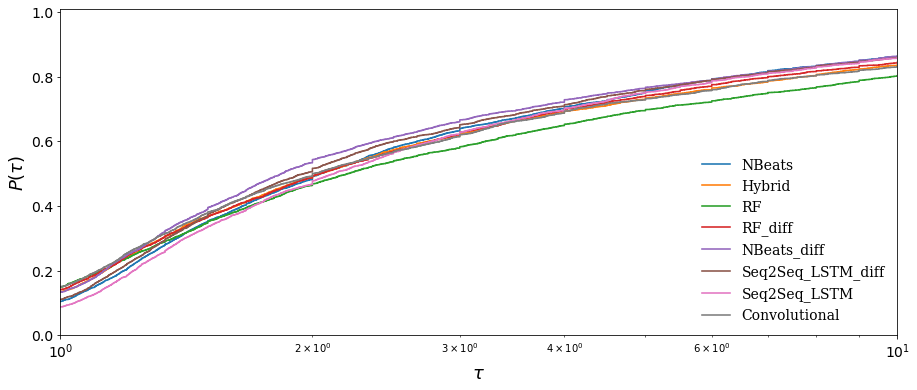

In [45]:
perfprof(df, 
         legendnames = df.columns,
         thmax       = 10, 
         figsize     = (15, 6))

plt.xscale('log')

# plt.ylim([0.1, 0.5])

# Statistical analysis

- Derrac, J., García, S., Molina, D., & Herrera, F. (2011). A practical tutorial on the use of nonparametric statistical tests as a methodology for comparing evolutionary and swarm intelligence algorithms. Swarm and Evolutionary Computation, 1(1), 3-18.

- García, S., Fernández, A., Luengo, J., & Herrera, F. (2010). Advanced nonparametric tests for multiple comparisons in the design of experiments in computational intelligence and data mining: Experimental analysis of power. Information sciences, 180(10), 2044-2064.

In [46]:
# df = df[:1000]

## Friedman Aligned Ranking (FAR)

In [47]:
T, p_value, rankings_avg, rankings_cmp = friedman_aligned_ranks_test( df )


# Summary
#
print('\n')
print('[INFO] H0: {All methods exhibited similar results with no statistical differences}')
print('[INFO] FAR: %.3f (p-value: %.5f)' % (T, p_value))
if (p_value < 0.05):
    print('\t> H0 is rejected')
else:
    print('\t> H0 is failed to be rejected')

[INFO] Number of methods:   8
[INFO] Number of problems:  4280


[INFO] H0: {All methods exhibited similar results with no statistical differences}
[INFO] FAR: 214.226 (p-value: 0.00000)
	> H0 is rejected


### FAR ranking

In [48]:
Ranking            = pd.DataFrame( [] )
Ranking['Methods'] = df.columns
Ranking['FAR']     = rankings_avg

Ranking = Ranking.sort_values(by           = 'FAR', 
                              ignore_index = True)
Ranking

,Methods,FAR
0,NBeats_diff,16208.047780
1,Seq2Seq_LSTM_diff,16328.976519
2,NBeats,16750.776285
3,RF_diff,16915.362033
4,Seq2Seq_LSTM,17073.558879
5,Convolutional,17291.743575
6,Hybrid,17348.341121
7,RF,19047.193808


## Finner post-hoc test

In [49]:
# Create dictionary with rankings
#
d = {}
for i, feature in enumerate( df.columns ):
    d[ feature ] = rankings_cmp[i] 

### Multiple comparisons ($1 \times N$)

**Finner post-hoc test**

In [50]:
comparisons, z_values, p_values, adj_p_values = finner_test( d )

Finner = pd.DataFrame( [] )
Finner['Comparisons']     = comparisons
Finner['APV']             = adj_p_values
Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

Finner = Finner.sort_values(by = 'APV', ascending = False, ignore_index = True)
Finner

[INFO] Control method:  NBeats_diff


,Comparisons,APV,Null hypothesis
0,NBeats_diff vs Seq2Seq_LSTM_diff,5.714199e-01,Failed to reject
1,NBeats_diff vs NBeats,1.291944e-02,Rejected
2,NBeats_diff vs RF_diff,1.304414e-03,Rejected
3,NBeats_diff vs Seq2Seq_LSTM,8.936151e-05,Rejected
4,NBeats_diff vs Convolutional,9.193461e-07,Rejected
5,NBeats_diff vs Hybrid,3.312599e-07,Rejected
6,NBeats_diff vs RF,0.000000e+00,Rejected


In [51]:
# Ranking['Methods'] = ['Seq2Seq LSTM (Hybrid)', 'Seq2Seq LSTM + (d-diff)', 'NBeats', 'NBeats + (d-diff)', 'RF + (d-diff)', 'Seq2Seq LSTM', 'RF']
# #
# Ranking = Ranking.sort_values(by = 'FAR', ignore_index = True)
# Ranking['APV'] = '-'
# Ranking['APV'][1:] = Finner['APV']
# Ranking['Null hypothesis'] = '-'
# Ranking['Null hypothesis'][1:] = Finner['Null hypothesis']
# Ranking


### Multiple comparisons ($N \times N$)

**Finner-multitest post-hoc test**

In [52]:
# comparisons, z_values, p_values, adj_p_values = finner_multitest(d)

# Finner = pd.DataFrame( [] )
# Finner['Comparisons']     = comparisons
# Finner['APV']             = adj_p_values
# Finner['Null hypothesis'] = Finner['APV'].apply(lambda x: 'Rejected' if x < 0.05 else 'Failed to reject')

# Finner